In [74]:
import pandas as pd
from sklearn.cluster import KMeans
from hdbscan import HDBSCAN
import umap
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

sys.path.append(os.path.abspath('..')) 

from utils.preproc_utils import *
from utils.plot_utils import *
from utils.modeling_utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
sys.path.append(os.path.abspath('..')) 
base_dir = os.path.abspath(os.path.join(os.getcwd(), '../../data/processed/'))

preproc_path = os.path.join(base_dir, 'customer_info_preproc.csv')
customer_info_preproc = pd.read_csv(preproc_path, index_col='customer_id')

preproc_path_outliers = os.path.join(base_dir, 'customer_info_preproc_outliers.csv')
customer_info_preproc_outliers = pd.read_csv(preproc_path_outliers, index_col='customer_id')

combined_data = pd.concat([customer_info_preproc, customer_info_preproc_outliers])

### **Clustering Without Outliers**

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


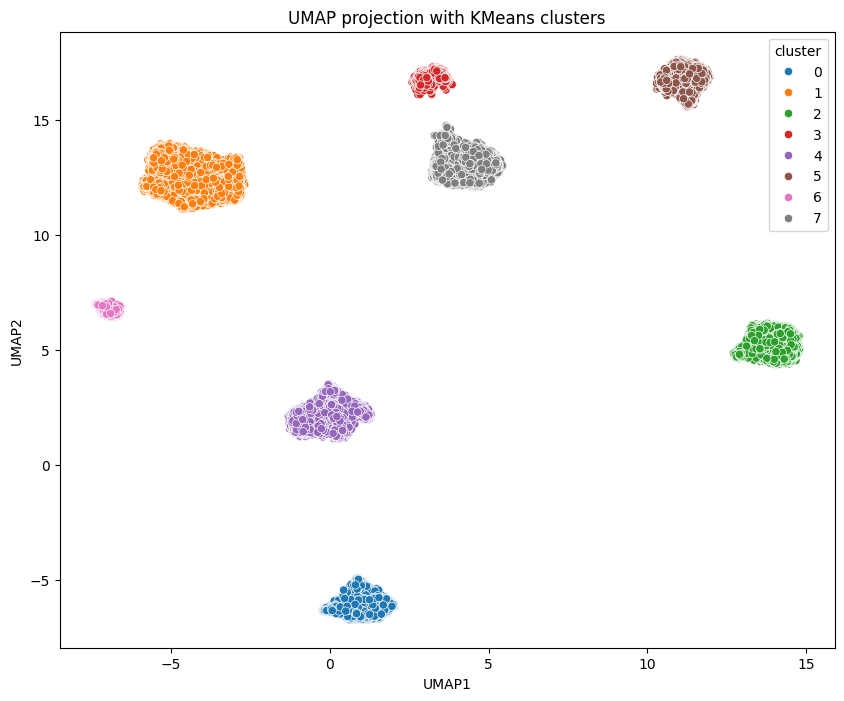

In [86]:
umap_reducer = umap.UMAP(n_neighbors=35, min_dist=0.0, n_components=2, random_state=42)
umap_embeddings_combined = umap_reducer.fit_transform(combined_data)

# split UMAP embeddings back into inliers and outliers
umap_embeddings = umap_embeddings_combined[:len(customer_info_preproc)]
umap_embeddings_outliers = umap_embeddings_combined[len(customer_info_preproc):]

# perform KMeans clustering on inliers
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans_labels = kmeans.fit_predict(umap_embeddings)

umap_df = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'], index=customer_info_preproc.index)
umap_df['cluster'] = kmeans_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='cluster', data=umap_df, palette='tab10')
plt.title('UMAP projection with KMeans clusters')
plt.show()

### **Appending Outliers to the Existent Clusters**

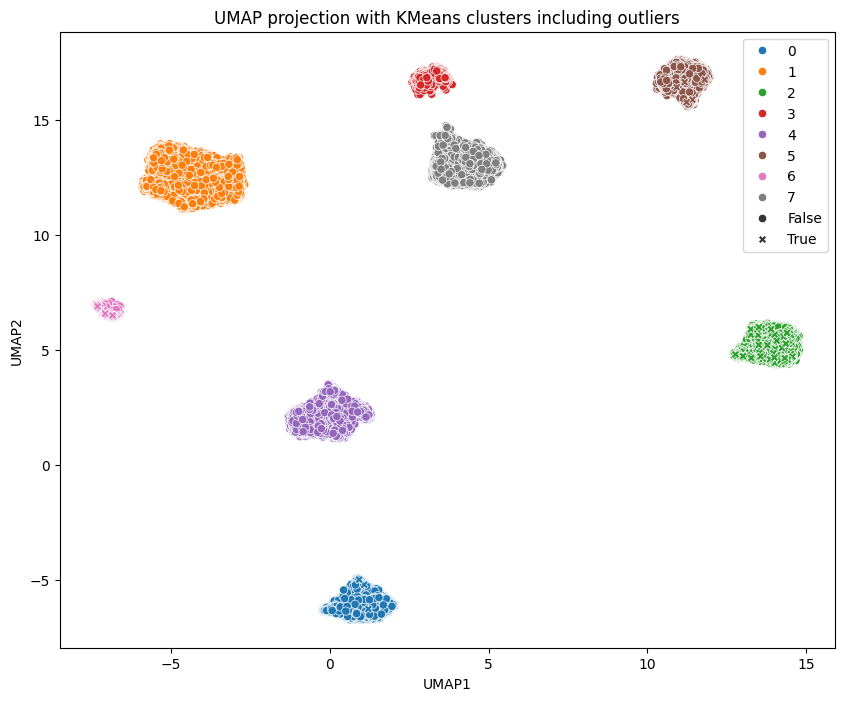

In [77]:
# k-Nearest Neighbors to classify outliers into existing clusters
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(umap_embeddings, kmeans_labels)

# predict clusters for outliers
outlier_clusters = knn.predict(umap_embeddings_outliers)

umap_df_outliers = pd.DataFrame(umap_embeddings_outliers, columns=['UMAP1', 'UMAP2'], index=customer_info_preproc_outliers.index)
umap_df_outliers['cluster'] = outlier_clusters

# combine the inliers and outliers for final visualization
final_umap_df = pd.concat([umap_df, umap_df_outliers])

plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='cluster', data=final_umap_df, palette='tab10', style=final_umap_df.index.isin(umap_df_outliers.index))
plt.title('UMAP projection with KMeans clusters including outliers')
plt.legend(loc='best')
plt.show()

### **Exporting the Clusters**

In [78]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), '../../data/raw/'))
customer_info = pd.read_csv(os.path.join(base_dir, 'customer_info.csv'), index_col='customer_id')
customer_info_clean = clean_customer_data(customer_info)

customer_info_clean_labeled = pd.merge(customer_info_clean, final_umap_df['cluster'], how='left', on='customer_id')

export_clusters(customer_info_clean_labeled, 'cluster')

### **Visualizing the Clusters**

In [79]:
karens = customer_info_clean[customer_info_clean['number_complaints'] > 3]
karens_idx = karens.index
karens_idx.shape

(126,)

In [80]:
cluster1 = final_umap_df[final_umap_df['cluster'] == 1]
cluster1.shape

(10836, 3)

In [81]:
# check if karens in cluster 1
karens_in_cluster1 = karens_idx.intersection(cluster1.index)
karens_in_cluster1.shape

(122,)

C:\Users\vic\AppData\Local\Temp\ipykernel_5440\2240809235.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_1_data['subcluster'] = ward_labels
C:\Users\vic\AppData\Local\Temp\ipykernel_5440\2240809235.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_1_data['new_cluster'] = cluster_1_data['subcluster'].apply(lambda x: 8 + x)  # Assuming 10 and 11 are new labels


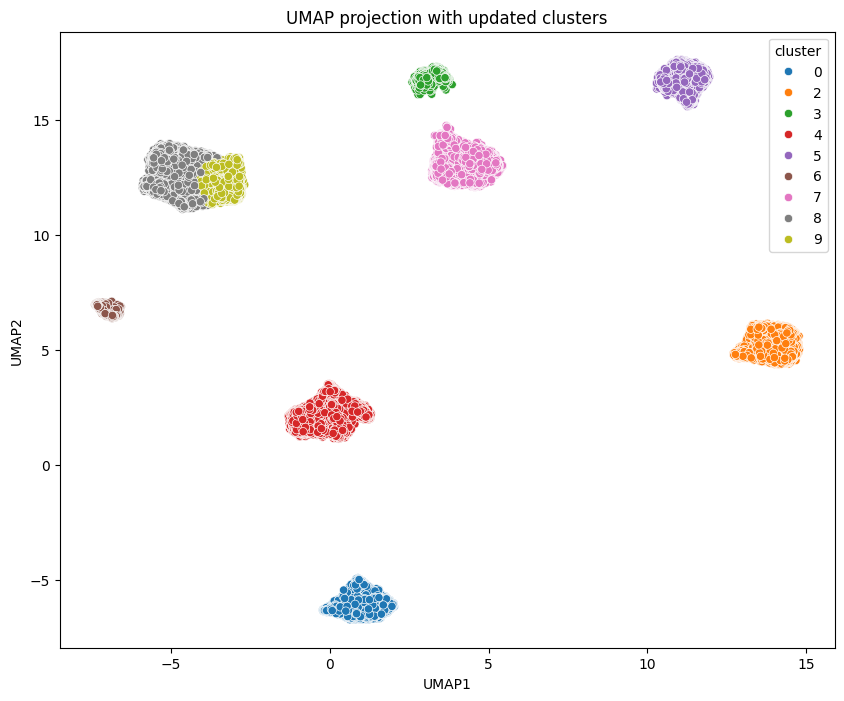

In [82]:
# apply hierarchical clustering on cluster 1
from sklearn.cluster import AgglomerativeClustering
cluster_1_data = final_umap_df[final_umap_df['cluster'] == 1]

ward = AgglomerativeClustering(n_clusters=2, linkage='ward')
ward_labels = ward.fit_predict(cluster_1_data[['UMAP1', 'UMAP2']])

cluster_1_data['subcluster'] = ward_labels

# Create a unique label for each subcluster within cluster 1
cluster_1_data['new_cluster'] = cluster_1_data['subcluster'].apply(lambda x: 8 + x)  # Assuming 10 and 11 are new labels

# Update the original DataFrame with the new cluster labels
final_umap_df.loc[cluster_1_data.index, 'cluster'] = cluster_1_data['new_cluster']

# Plot UMAP projection with updated clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='cluster', data=final_umap_df, palette='tab10')
plt.title('UMAP projection with updated clusters')
plt.show()